# Import useful libraries

In [1]:
import numpy as np # Numerical computing library dealing with multi-dimensional matrices 
import pandas as pd # Open-source data manipulation and analysis library
import nltk # Natural Language Toolkit
import re # Working with regular expressions.
import string
from nltk.corpus import stopwords # Contains the stopwords like "und, aber, als, oder, ..."
from nltk.tokenize import word_tokenize # To split the text into individual words or tokens
from nltk.stem import PorterStemmer # To reduce words to their base or root form
from sklearn.preprocessing import LabelEncoder # To encode the target variable 

# Loading dataset

In [2]:
data_df = pd.read_csv('sample_data.csv')
data_df.head(60)

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft
5,Lebensmittel Organic Getränke,ft
6,plastikflaschen abfälle,pkg
7,Knoblauch frisch,ft
8,Lohnarbeiten für Druckguss,ct
9,etiketten metall,pkg


# Trying to understand dataset

In [3]:
# Get unique labels in the 'label' column
unique_labels = data_df['label'].unique()
unique_labels

array(['ft', 'mr', 'ct', 'pkg', 'ch', 'cnc', nan], dtype=object)

In [4]:
label_counts = data_df['label'].value_counts()
print("Label Counts:")
print(label_counts)

Label Counts:
label
ft     11226
pkg     9617
ct      5061
mr      5016
ch      3688
cnc     2587
Name: count, dtype: int64


In [5]:
nan_count_label = data_df['label'].isna().sum()
print("Number of NaN values in 'label' column:", nan_count_label)

Number of NaN values in 'label' column: 100


In [6]:
nan_count_text = data_df['text'].isna().sum()
print("Number of NaN values in 'text' column:", nan_count_text)

Number of NaN values in 'text' column: 0


we have relatively large dataset (37295 examples) and only a small portion of it (100 examples) has missing labels, so from my perspective might consider the following approach:

Remove Examples with Missing Labels:

Since the number of examples with missing labels is small in comparison to the overall dataset, removing these examples might be a reasonable choice, and if the number of examples with missing labels is relatively small and won't significantly impact the model's performance.

In [7]:
# after executing this cell will have 37195 exampels
data_df = data_df.dropna(subset=['label'])
data_df 

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft
...,...,...
37290,spirituosen dienstleister,ft
37291,mini hydraulikzylinder,ct
37292,blockbodenbeutel verpackungen,pkg
37293,Drehteile verpacken,mr


I observed that there are some chinese text so this is not german search query like exmaple(44) --> (text:吉祥 , label:mr) so i will remove it

In [8]:
chinese_pattern = re.compile('[\u4e00-\u9fff]+')  # Unicode range for Chinese characters
data_df = data_df[~data_df['text'].str.contains(chinese_pattern)]

In [9]:
# Remove rows where 'text' column contains only numbers
data_df = data_df[~data_df['text'].str.isnumeric()]

In [10]:
data_df.head(10)

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft
5,Lebensmittel Organic Getränke,ft
6,plastikflaschen abfälle,pkg
7,Knoblauch frisch,ft
8,Lohnarbeiten für Druckguss,ct
9,etiketten metall,pkg


# Preprocessing dataset

1- Lowercasing:(Convert all text to lowercase. This ensures consistency in your data and helps the model treat words in a case-    insensitive manner.)

2- Removing Punctuation: (Remove any unnecessary punctuation from the text)

3- Removing Stopwords and Tokenization: (Remove common words that don't carry much meaning (stopwords)) ---> (Split the text into individual words or tokens. This is a crucial step for most natural language processing tasks.)

4- Stemming or Lemmatization:(Reduce words to their base or root form. This step can help in reducing the dimensionality of the    data and improving model performance.)

5- Label encoding for the target variable

In [11]:
# Download necessary resources from NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
def process_text(dataframe, text_column, label_column):
    # Step 1: will convert the text to lowercase
    dataframe[text_column] = dataframe[text_column].str.lower()
    # Step 2: will remove special characters and numbers "Remove punctuation"
    # It replaces any character that is not a lowercase letter (a-zäöüß) or whitespace (\s) with an empty string ''. The ^ inside the square brackets negates the character set
    dataframe[text_column] = dataframe[text_column].apply(lambda x: re.sub(r'[^a-zäöüß\s]', '', x))
    # Step 3: Tokenization and remove stopwords
    stop_words = set(stopwords.words('german'))
    dataframe[text_column] = dataframe[text_column].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
    # word_tokenize(x): This function tokenizes the text string x into a list of words.
    # [word for word in word_tokenize(x) if word.lower() not in stop_words]: here iterates through each word in the tokenized list, checks if the lowercase version of the word is not in the stop_words set, and keeps only those words that are not stopwords.
    # ' '.join(...): This part joins the filtered list of words back into a sentence, separated by spaces.
    # Step 4: Stemming using PorterStemmer
    porter_stemmer = PorterStemmer()
    dataframe[text_column] = dataframe[text_column].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in word_tokenize(x)]))
    # Step 5: Label encoding for the target variable
    # The LabelEncoder is commonly used for encoding categorical target labels with numerical values.
    label_encoder = LabelEncoder()
    dataframe[label_column] = label_encoder.fit_transform(dataframe[label_column])    
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    # Display the class mapping
    print("Class Mapping:")
    for class_label, numerical_code in class_mapping.items():
        print(f"{class_label}: {numerical_code}")

    # Display the encoded classes in the DataFrame
    print("\nEncoded classes in the DataFrame:", dataframe[label_column].unique())
    
    return dataframe

    

In [13]:
processed_df= process_text(data_df, 'text', 'label')
processed_df

Class Mapping:
ch: 0
cnc: 1
ct: 2
ft: 3
mr: 4
pkg: 5

Encoded classes in the DataFrame: [3 4 2 5 0 1]


,text,label
0,zucker fabrik,3
1,lebensmittel kommssionierung,3
2,geländer biegen,4
3,gebäudeausrüstung technisch,2
4,kürbiskernöl softgel,3
...,...,...
37290,spirituosen dienstleist,3
37291,mini hydraulikzylind,2
37292,blockbodenbeutel verpackungen,5
37293,drehteil verpacken,4


In [14]:
nan_count_text_after_process_text = processed_df['text'].isna().sum()
print("Number of NaN values in 'text' column:", nan_count_text_after_process_text)

Number of NaN values in 'text' column: 0


We observe that for example (smaple 8 was "Lohnarbeiten für Druckguss" and after processing become "lohnarbeiten druckguss")

# Preparing the dataset for machine learning model

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    processed_df['text'],  # Features (text)
    processed_df['label'],  # Labels
    test_size=0.2,  # 80% training, 20% testing
    random_state=42  # Set a random seed for reproducibility
)

In [16]:
# Here for the clarification of the Shapes of splitting dataset
print("Number of the examples in Training set :",X_train.shape[0])
print("Number of the examples in Test set :",X_test.shape[0])

Number of the examples in Training set : 29276
Number of the examples in Test set : 7319


# Text Vectorization
 Here I convert the text data into a format that can be used by machine learning algorithms. This often involves transforming the text into numerical vectors

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()  # Adjust the max_features parameter
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [18]:
print("Shape of TF-IDF matrix:", X_train_tfidf.shape)
print("Shape of the first example:",X_train_tfidf[0].shape)
print("First row of TF-IDF matrix:", X_train_tfidf[0].toarray())

Shape of TF-IDF matrix: (29276, 15885)
Shape of the first example: (1, 15885)
First row of TF-IDF matrix: [[0. 0. 0. ... 0. 0. 0.]]


 matrix: (29276, 15885)" indicates that your TF-IDF matrix has 29,276 rows and 15,885 columns.
 
 29,276 is the number of examples in training set.
 
 15,885 is the number of unique words (features) in the training set.
 
 This means that TF-IDF matrix has one row for each document in your training set, and each document is represented by a   vector in a space with 15,885 dimensions. Each dimension corresponds to a unique word in your training set.

# Model Training

Multinomial Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)

# Make predictions
predictions_nb = model_nb.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, predictions_nb))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       694
           1       0.91      0.55      0.69       498
           2       0.95      0.87      0.90      1019
           3       0.82      0.93      0.87      2227
           4       0.84      0.82      0.83       986
           5       0.82      0.89      0.86      1895

    accuracy                           0.85      7319
   macro avg       0.89      0.80      0.83      7319
weighted avg       0.86      0.85      0.85      7319



In [20]:
# New text input
new_text = "Lebensmittel kommssionierung"

# Transform the new text into TF-IDF features
new_text_tfidf = tfidf_vectorizer.transform([new_text])

# Make predictions
new_predictions = model_nb.predict(new_text_tfidf)

# Print the predicted class label(s)
print("Predicted Class Label(s):", new_predictions)

Predicted Class Label(s): [3]


- True Positive: model predicted correctly as positive and the actual class was positive
- True Negative: model predicted correctly as negative and the actual class was negative
- False Positive: model predicted incorrectly as positive and the actual class was negative
- False Negative: model predicted incorrectly as negative and the actual class was positive

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives.
  - precision = True Positives / (True Positives + False Positives) 
  - It gives an indication of how many instances predicted as positive are actually positive.

Recall (Sensitivity or True Positive Rate): Recall is the ratio of correctly predicted positive observations to all the actual positives.
   - Recall = True Positives / (True Positives + False Negatives)
   - It indicates how many actual positive instances are correctly predicted.

F1-Score: The F1-score is the harmonic mean of precision and recall, providing a balance between the two.
   - F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
   - It is a single metric that considers both false positives and false negatives.

Support: Support is the number of actual occurrences of the class in the specified dataset.
It gives the number of samples in each class.

Accuracy: Accuracy is the ratio of correctly predicted observations to the total observations
  - Accuracy = (TP + TN) / (TP + TN + FP + FN).
  - It provides an overall measure of how well the model is performing.

Explanation of results for (0) class:

precision:
 - Precision for class 0 is 0.97, which means that out of all instances predicted as class 0, 97% were correct.
 - In the context of your specific task, when the model predicts class 0 (the actual label is 0), it is correct 97% of the time.

recall:
 - Recall for class 0 is 0.74, indicating that the model correctly identified 74% of all instances that truly belong to class 0.
 - In other words, out of all instances that are actually class 0, the model correctly predicted 74% of them.
 
Support (694):

- Support is the number of actual occurrences of the class in the specified dataset (test set, in this case).
- For class 0, there are 694 instances in the test set.

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, predictions_nb)
print(f"Accuracy for Multinomial Naive Bayes: {accuracy_nb:.4f}")

Accuracy for Multinomial Naive Bayes: 0.8538


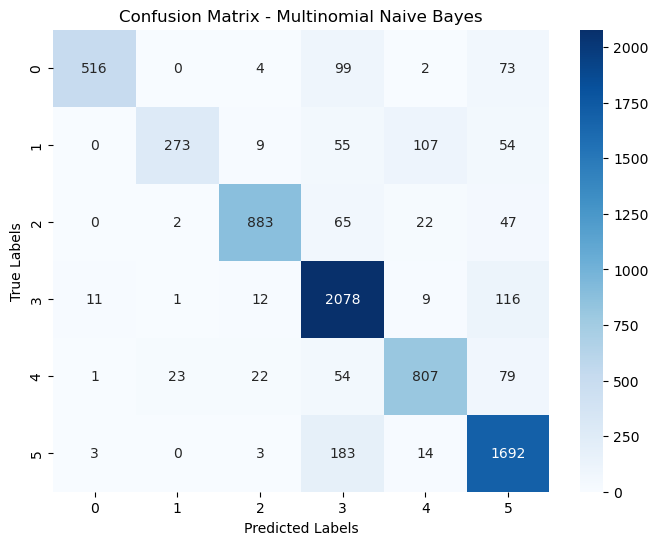

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate and display confusion matrix
conf_matrix_nb = confusion_matrix(y_test, predictions_nb)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Preparing for Dockerized
I use the Pipeline package to make the two steps (vectorizer, Training Model) in one step as pipeline so that easy to save the model also via Pickle package

In [23]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('vectorizer',tfidf_vectorizer),('MultinomialNB',model_nb)])
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])

In [24]:
y_pred2 = pipe.predict(X_test)
accuracy_nb2 = accuracy_score(y_test,y_pred2)
print(f"Accuracy for Multinomial Naive Bayes: {accuracy_nb2:.4f}")

Accuracy for Multinomial Naive Bayes: 0.8538


# Saving the trained model

In [25]:
import pickle

#This allows to save the trained model to disk and load it later for making predictions or further analysis. 
with open('trained_pipeline_0.1.0.pkl','wb') as f:
    pickle.dump(pipe,f)